First download the gear images using; 

* curl -O https://challenge.blob.core.windows.net/challengefiles/gear_images.zip
* unzip *.zip

Or in windows powershell;

* wget "https://challenge.blob.core.windows.net/challengefiles/gear_images.zip" -OutFile gear_images.zip
* unzip gear_images.zip

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle
from pipe import Pipe
from functools import reduce
import operator
from pipe import select,take,as_list
from sklearn import tree
from glob import glob
from PIL import Image
import numpy as np
import re

#Inline Matplot graphics into the notebook
%matplotlib inline 

def resizeImageToSquare(image, desiredSize):
    # old_size[0] is in (width, height) format
    oldSize = image.size

    ratio = float(desiredSize)/max(oldSize)
    newSize = tuple([int(x*ratio) for x in oldSize])

    image = image.resize(newSize, Image.BICUBIC)
    # create a new image and paste the resized on it
    resized = Image.new("L", (desiredSize, desiredSize),0xffffff)
    resized.paste(image, ((desiredSize-newSize[0])//2,
                        (desiredSize-newSize[1])//2))
    return resized

* Load all the gear_images 
* Resize them to 128^2
* Make black and white (we don't want to learn particular colours of tents etc)
* Scale image numbers $\in [0,1]$

In [171]:
%%time

@Pipe
def as_npy(iterable):
    return np.array(iterable)

def getImageTypeFromPath(imagePath):
    return re.search('[^\w](\w+)[^\w]', imagePath)[1]

# note I have obfuscated the names so that people can not google the solutions
imageTypes = {
    'axes': 0, 
    'boots': 1, 
    'carabiners': 2,
    'crampons': 3, 
    'gloves': 4, 
    'hardshell_jackets': 5, 
    'harnesses': 6, 
    'helmets': 7, 
    'insulated_jackets': 8, 
    'pulleys': 9, 
    'rope': 10, 
    'tents': 11, 
}

imageTypesInverted = {v: k for k, v in imageTypes.items()}

xy = ( glob("gear_images/**/*")  
    | select(lambda path: (imageTypes[getImageTypeFromPath(path)], Image.open(path)))     
    # make black and white
    | select(lambda t: (t[0], t[1].convert('L') ) )     
    # make square
    | select(lambda t: (t[0], resizeImageToSquare(t[1], 128)) )     
    | select(lambda t: (t[0], np.array(t[1])))     
    # scale to [0,1]
    | select(lambda t: (t[0], t[1] / 255))     
    | as_list() )

X = xy | select(lambda e: e[1]) | as_list() | as_npy()

# flattened version for classical learning
Xf = X.reshape( X.shape[0], reduce(operator.mul, X.shape[1:], 1)  )
y = xy | select(lambda e: e[0]) | as_list() | as_npy()

print("X", X.shape, "y", y.shape)

X (2122, 128, 128) y (2122,)
Wall time: 8.06 s


Let's plot some of the images so we can see what we are working with

In [77]:
def plotSome(x, y, name='axes'):
    fig = plt.figure(figsize=(8, 6))
    # plot several images
    for i in range(15):
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x[y==imageTypes[name]][i], cmap=plt.cm.bone)

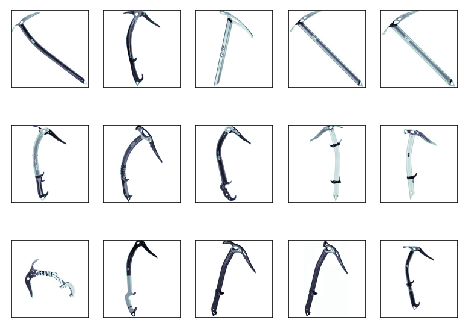

In [194]:
plotSome(X,y,'axes')

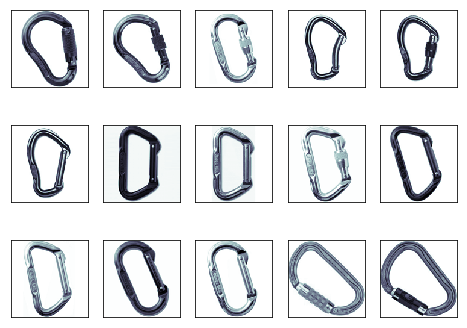

In [195]:
plotSome(X,y,'carabiners')

Let's try plotting one image for every class

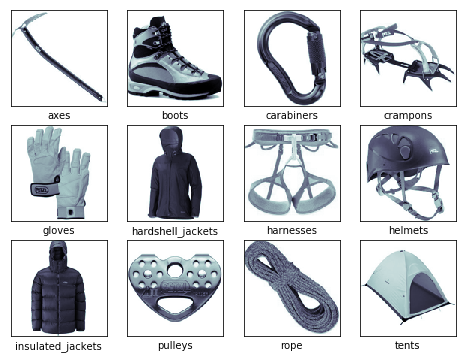

In [81]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X[y==imageTypes[key]][0], cmap=plt.cm.bone)
    ax.set_xlabel(key)
    i = i + 1

Let's get a bit more clever now and plot an average image for each class. The result is prettu instructive;

* We can see that roughly half of the boots are inverted
* In most cases there is a clear "signature" to the class, this is part of why this challenge is quite contrived, similar to the MNIST challenge, it should be possible to guess what the class is merely by choosing values for pixels in certain areas. 

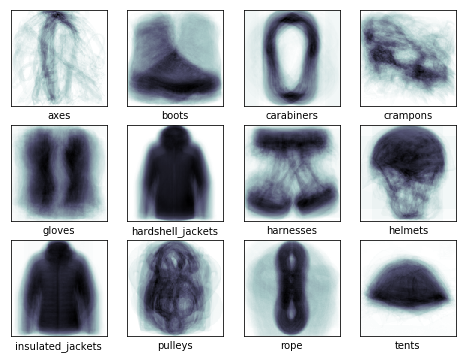

In [82]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X[y==imageTypes[key]].mean(axis=0), cmap=plt.cm.bone)
    ax.set_xlabel(key)
    i = i + 1

Let's look at the intensity histogram for each class average. This is interesting;

* In the olden days of computer vision, the onus was on the data scientists themselves to transform the data out of the space domain using some feature. This is the most basic version of that. 
* The reason we used to have transform out of the space domain was that classical algorithms themselves can not learn spatial relationships between pixels and the assumption is that images are typically taken from a variety of angles/environments which *should* render pixel-by-pixel mapping methods unworkable. 
* Turns out that here, while there are some differences between the classes, clearly the previous (2d spatial) information is more instructive to seperate the class

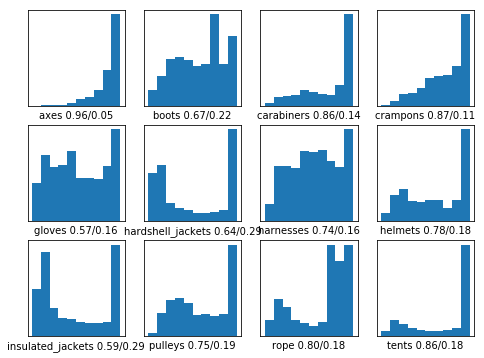

In [83]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    ax.hist(x)
    ax.set_xlabel( f"{key} {x.mean():.2f}/{x.std():.2f}" ) 
    i = i + 1

What is the average image over everything?

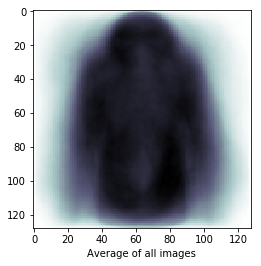

In [151]:
def PlotAverageImage(D):
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    plt.imshow(D.mean(axis=0), cmap=plt.cm.bone)
    u = plt.xlabel( f"Average of all images" ) 

PlotAverageImage(X)

Jackets seem to be dominating, could this be because;

* The intensity values are higher in jackets
* There are more jackets overall (remember insulated jackets + normal jackets)


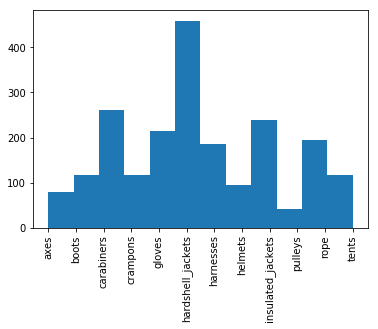

In [134]:
u = plt.hist(le.transform(y), bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

It does indeed appear that our hardshell jackets are dominating due to there being many more of them, also the jackets are around 200 and will have a similar profile which will compound the problem

Let's balance the distribution of classes by supersampling

In [153]:
from pipe import chain, as_dict, Pipe, select, take, as_list

@Pipe
def pcycle(iterable):
    while True:
        for it in iterable:
            yield it
        
@Pipe
def as_npy(iterable):
    return np.array(iterable)

def balancedSignalGenerator(X,y,num_classes=12):
    
    class_map = {}
    for c in range(num_classes):
        class_map[c] = list(np.where( y==c)[0])
                            
    D = range(num_classes) \
        | select( lambda c: class_map[c] | pcycle | select( lambda i: (c,X[i]) )  ) \
        | as_list

    while True:
        for c in D:
            yield next(c)[0], next(c)[1]

        
data = balancedSignalGenerator(X,y) | take(5000) | as_list

Xbal = data | select(lambda el: el[1])  | as_list | as_npy
ybal = data | select(lambda el: el[0])  | as_list | as_npy

And we are now balanced!

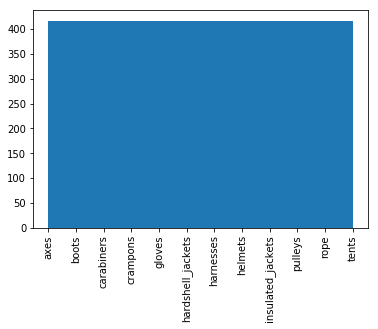

In [154]:
plt.hist(ybal,bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

Now, let's plot the average image again. This looks a little bit more reasonable i.e. there is a consistent "contribution" to the mixture from all 12 classes. If anything it's now the rope which is slightly dominating, I assume because its being "boosted" from mixing with the jackets which entirely intersect. 

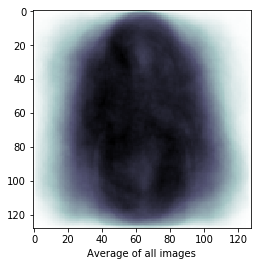

In [155]:
PlotAverageImage(Xbal)

Let's split the data into a test and train set

In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xbal,
        ybal, random_state=0)

print(X_train.shape, X_test.shape)

(3750, 128, 128) (1250, 128, 128)


Helper function to convert label indexes i.e. {0,1,2...} into labels i.e. {"axes","carabiners"...}

In [213]:
def ConvertIndexToLabel(indexes):
    return list( indexes ) | select( lambda i: imageTypesInverted[i] ) | as_list 

Let's run a basic decision tree algorithm on the data i.e. ID3 algorithm

In [251]:
%%time

from sklearn import tree
from sklearn import metrics

def ID3(xtrain,xtest,ytest):
    classifier = tree.DecisionTreeClassifier()
    clf = classifier.fit(xtrain.reshape(xtrain.shape[0], 128*128), y_train)
    y_pred = clf.predict(xtest.reshape(xtest.shape[0], 128*128))
    print(
        metrics.classification_report(
            ConvertIndexToLabel(ytest), 
            ConvertIndexToLabel(y_pred)
        ))
    return y_test, y_pred

y_test, y_pred = ID3(X_train, X_test, y_test)

                   precision    recall  f1-score   support

             axes       1.00      1.00      1.00       104
            boots       0.96      1.00      0.98        89
       carabiners       1.00      1.00      1.00       117
         crampons       1.00      1.00      1.00       101
           gloves       0.90      0.95      0.92        96
hardshell_jackets       0.96      0.88      0.92        92
        harnesses       1.00      0.96      0.98       110
          helmets       0.99      1.00      1.00       110
insulated_jackets       0.90      0.94      0.92       121
          pulleys       1.00      1.00      1.00        97
             rope       1.00      0.96      0.98        97
            tents       1.00      1.00      1.00       116

      avg / total       0.98      0.98      0.98      1250

Wall time: 28.5 s


Incredibly... we get 0.97f-1 on this. Usually the candidates get about .77f-1 or something but they typically don't supersample and balance the data. Let's try the same thing again on the original data;

In [243]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X,
        y, random_state=0)

print(X_train.shape, X_test.shape)
    
y_test, y_pred = ID3(X_train, X_test, y_test)

(1591, 128, 128) (531, 128, 128)
                   precision    recall  f1-score   support

             axes       0.68      0.75      0.71        28
            boots       0.81      0.77      0.79        22
       carabiners       0.86      0.81      0.84        63
         crampons       0.81      0.66      0.72        38
           gloves       0.67      0.75      0.70        51
hardshell_jackets       0.72      0.84      0.78       106
        harnesses       0.80      0.73      0.77        45
          helmets       0.75      0.62      0.68        24
insulated_jackets       0.66      0.57      0.61        68
          pulleys       0.33      0.21      0.26        14
             rope       0.71      0.86      0.78        43
            tents       0.93      0.90      0.91        29

      avg / total       0.74      0.74      0.74       531

Wall time: 17.2 s


Wow -- so on the unbalanced dataset the results drop down to about .74 average f-1 which is what most of the candidates on the openhack get. Who would have thought simply balancing the class distribution was all you needed to do to get .97!

Actually this is brilliant because it emphasises the point I want to make in this notebook even better i.e. you might think at this stage that you have an amazing model -- but it's such a contrived example and is most likely learning nothing whatsoever about our actual items :) 

This is when the real investigation begins...

Here is a function which let's us plot a nice confusion matrix

In [226]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plotConfusion(yy, p, title='Confusion matrix'):
    cnf_matrix = metrics.confusion_matrix(yy, p)
    np.set_printoptions(precision=2)

    cm_labels = list(set(imageTypes.keys()))
    cm_labels.sort()

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                          title=title)

Here is the confusion matrix for the unbalanced original set. Clearly the biggest problem is (or was) confusing the two jacket classes

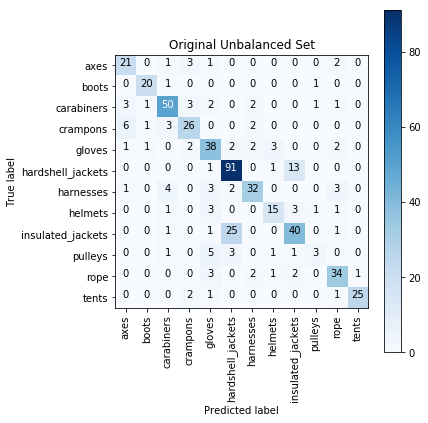

In [227]:
plotConfusion(y_test, y_pred, title='Original Unbalanced Set')

Let's revert back to the balanced split

In [252]:
X_train, X_test, y_train, y_test = train_test_split(Xbal,
        ybal, random_state=0)

print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)

(3750, 128, 128) (3750,) (1250, 128, 128) (1250,)


Now let's add some white noise to the backgrounds, the hypothesis on the table is that it's just learning where the white pixels are...

In [233]:
%%time

from random import uniform
from pipe import take, select, as_list, Pipe

import random
@Pipe
def pshuffle(l):
    random.shuffle(l)
    return l

def noiseImages( images ):
    images_whitenoise = images

    mask = images_whitenoise>0.95
    vals = range(np.count_nonzero(mask)) | select( lambda n: uniform(0, 1)) | as_list()

    # Assign back into X
    images_whitenoise[mask] = vals
    return images_whitenoise
    
X_test_whitenoise = noiseImages( X_test )
X_train_whitenoise = noiseImages( X_train )

And let's plot 16 test images to see if the backgrounds have been noised

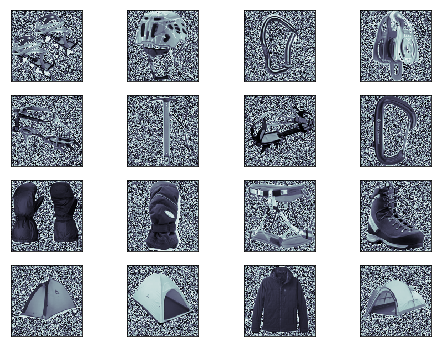

In [239]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

noisy_images = range( X_test_whitenoise.shape[0] )     \
    | as_list()     \
    | pshuffle()     \
    | take(16)     \
    | select( lambda i: X_test_whitenoise[i] )     \
    | as_list()

fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for img in noisy_images:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img.reshape(128,128), cmap=plt.cm.bone)
    i = i + 1

Now let's run trees (ID3) on noisy images, we are expecting the accuracy to plummet

In [253]:
%%time

y_test, y_pred = ID3(X_train_whitenoise, X_test_whitenoise, y_test)

                   precision    recall  f1-score   support

             axes       0.20      0.17      0.18       104
            boots       0.73      0.81      0.77        89
       carabiners       0.29      0.21      0.25       117
         crampons       0.35      0.39      0.37       101
           gloves       0.58      0.58      0.58        96
hardshell_jackets       0.45      0.60      0.51        92
        harnesses       0.33      0.33      0.33       110
          helmets       0.53      0.52      0.52       110
insulated_jackets       0.76      0.74      0.75       121
          pulleys       0.83      0.89      0.86        97
             rope       0.45      0.49      0.47        97
            tents       0.52      0.46      0.49       116

      avg / total       0.50      0.51      0.50      1250



And indeed, the accuracy plumets to .5f-1 score!! Ouch.

It's now shockingly bad on axes and carabiners

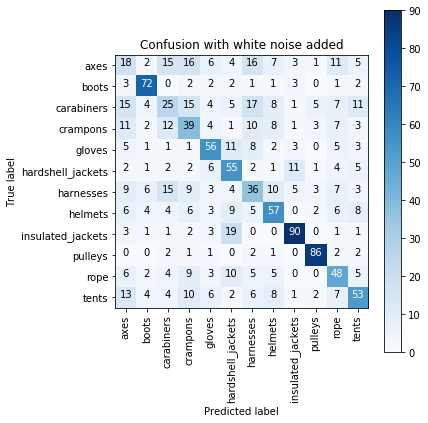

In [254]:
plotConfusion(y_test, y_pred, title='Confusion with white noise added')

The hypothesis on the table is that a CNN would work better because it can model local spatial patterns which are somewhat invariant to translation

First to use a CNN we need to add an explicit colour channel back in, even if it's only 1, also we need to one-hot encode the labels

In [261]:
from keras.utils import to_categorical

X_train_whitenoise_1 = X_train_whitenoise.reshape(3750,128,128,1)
Yone = to_categorical(y_train, num_classes=12)
YValone = to_categorical(y_test, num_classes=12)
X_test_whitenoise_1 = X_test_whitenoise.reshape(1250,128,128,1)

In [263]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train_whitenoise_1, Yone, 
                    epochs=5, batch_size=20, 
                    validation_data=(X_test_whitenoise_1, YValone))


Train on 3750 samples, validate on 1250 samples
Epoch 1/5
3750/3750 [==============================] - 190s 51ms/step - loss: 1.0107 - acc: 0.7256 - val_loss: 0.1705 - val_acc: 0.9392
Epoch 2/5
3750/3750 [==============================] - 189s 50ms/step - loss: 0.0668 - acc: 0.9784 - val_loss: 0.0876 - val_acc: 0.9736
Epoch 3/5
3750/3750 [==============================] - 187s 50ms/step - loss: 0.0096 - acc: 0.9987 - val_loss: 0.1433 - val_acc: 0.9584
Epoch 4/5
3750/3750 [==============================] - 187s 50ms/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0643 - val_acc: 0.9760
Epoch 5/5
3750/3750 [==============================] - 185s 49ms/step - loss: 1.9142e-04 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9776


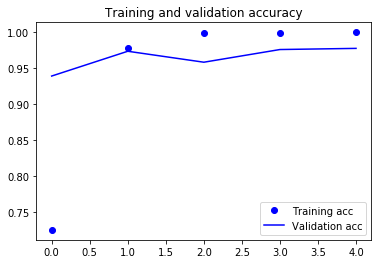

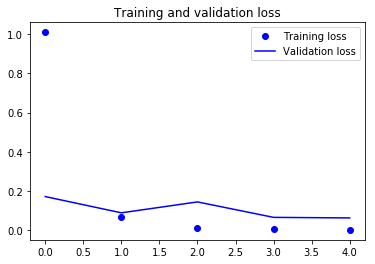

In [264]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [269]:
from numpy import argmax
y_pred = model.predict(X_test_whitenoise_1)
y_pred.shape
print(metrics.classification_report(ConvertIndexToLabel(y_test), ConvertIndexToLabel(argmax(y_pred,axis=1))))

                   precision    recall  f1-score   support

             axes       0.95      1.00      0.98       104
            boots       1.00      1.00      1.00        89
       carabiners       1.00      0.96      0.98       117
         crampons       1.00      1.00      1.00       101
           gloves       0.96      0.99      0.97        96
hardshell_jackets       0.92      0.88      0.90        92
        harnesses       0.99      1.00      1.00       110
          helmets       1.00      1.00      1.00       110
insulated_jackets       0.91      0.91      0.91       121
          pulleys       1.00      1.00      1.00        97
             rope       1.00      1.00      1.00        97
            tents       1.00      1.00      1.00       116

      avg / total       0.98      0.98      0.98      1250



In [ ]:
plotConfusion(y_test, y_pred, title='Confusion with white noise added')